In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt
import pyworld as pw
import pysptk as ps
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn as sk

# model

In [3]:
from model.main import SplitterNet

# data

## transform

In [4]:
from data.dataset import TransSqueeze, TransChunked

## dataset

In [5]:
from data.dataset import JVSDataset

# 入力確認

In [6]:
model = SplitterNet()
model.test_input()

encoder out *2
torch.Size([64, 64, 4, 4])
decoder out
torch.Size([64, 1, 32, 32])


# eval

In [7]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [8]:
import glob
pa = glob.glob("logs/lightning_logs/version_168/checkpoints/epoch=*.ckpt")[-1]

In [9]:
model = model.load_from_checkpoint(pa)

In [10]:
model.eval()

SplitterNet(
  (content_encoder): ContentEncoder(
    (lr): GLU(dim=1)
    (conv1): Conv2d(1, 16, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 32, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 64, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 64, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(32, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 1), bias=False)
  )
  (attribute_encoder): AttributeEncoder(
    (lr): GLU(dim=1)
    (conv1): Conv2d(1, 16, kernel_size=(1, 9),

In [11]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [12]:
x = torchaudio.load(wav_paths.collect_files()[100])[0]
tmp = torchaudio.load(wav_paths.collect_files()[401])[0][:, :180224]
print(x.shape)
print(tmp.shape)

torch.Size([1, 180224])
torch.Size([1, 180224])


In [13]:
def ex_mc(x):
    f0, sp, ap = pw.wav2world(x.squeeze(0).to(torch.double).numpy(), 24000)
    mc = ps.sp2mc(sp, order=31, alpha=ps.util.mcepalpha(24000))
    mc = torch.from_numpy(mc.T)
    return mc, f0, sp, ap

In [14]:
def synth(mc, f0, ap):
    mc = mc.T.numpy()
    sp = ps.mc2sp(mc, alpha=ps.util.mcepalpha(24000), fftlen=1024)
    sp = sp.astype(np.double)[:len(f0)]
    print(sp)
    return pw.synthesize(f0, sp, ap, 24000)

## 元音声の再合成

In [15]:
x_mc, x_f0, x_sp, x_ap = ex_mc(x)
xx = synth(x_mc, x_f0, x_ap)

[[2.06700875e-07 2.06593215e-07 2.06311051e-07 ... 1.49484492e-10
  1.49307378e-10 1.49248369e-10]
 [5.26138368e-07 5.22945427e-07 5.14400970e-07 ... 5.18052987e-10
  5.17248649e-10 5.16980489e-10]
 [1.07272032e-08 1.07303085e-08 1.07393054e-08 ... 4.60854269e-10
  4.60261142e-10 4.60063377e-10]
 ...
 [6.91611004e-08 6.94858701e-08 7.04088015e-08 ... 6.48161887e-10
  6.47026272e-10 6.46647936e-10]
 [7.73044162e-07 7.82377979e-07 8.08670675e-07 ... 6.54213475e-10
  6.52483362e-10 6.51906929e-10]
 [4.53432266e-08 4.55526725e-08 4.61306434e-08 ... 6.69345042e-10
  6.68999893e-10 6.68884616e-10]]


In [16]:
import IPython.display
IPython.display.Audio(xx, rate=24000)

(1, 180240)


/tmp/ipykernel_1078855/2825384265.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")


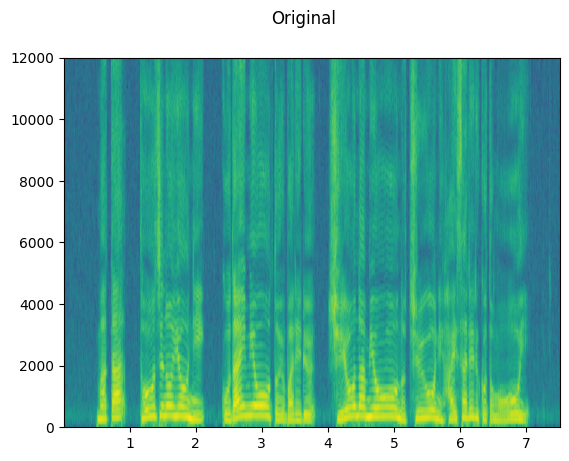

In [17]:
plot_specgram(torch.tensor([xx]), sample_rate=24000, title="Original")

In [18]:
tmp_mc, tmp_f0, tmp_sp, tmp_ap = ex_mc(tmp)
tmptmp = synth(tmp_mc, tmp_f0, tmp_ap)

[[1.49198967e-08 1.49610078e-08 1.50767570e-08 ... 3.34275956e-10
  3.36518844e-10 3.37270648e-10]
 [8.67228064e-08 8.68224184e-08 8.71090748e-08 ... 3.20088227e-10
  3.20311848e-10 3.20386411e-10]
 [6.29293314e-08 6.26765829e-08 6.19900416e-08 ... 3.83464473e-11
  3.83807646e-11 3.83922483e-11]
 ...
 [4.35802014e-06 4.33237207e-06 4.26247185e-06 ... 9.34980908e-09
  9.32231873e-09 9.31316505e-09]
 [9.99983920e-06 9.94072095e-06 9.78026359e-06 ... 8.45959745e-09
  8.43086966e-09 8.42130742e-09]
 [1.98448960e-05 1.97366522e-05 1.94484784e-05 ... 9.67984045e-09
  9.64035348e-09 9.62720469e-09]]


In [19]:
import IPython.display
IPython.display.Audio(tmptmp, rate=24000)

(1, 180240)


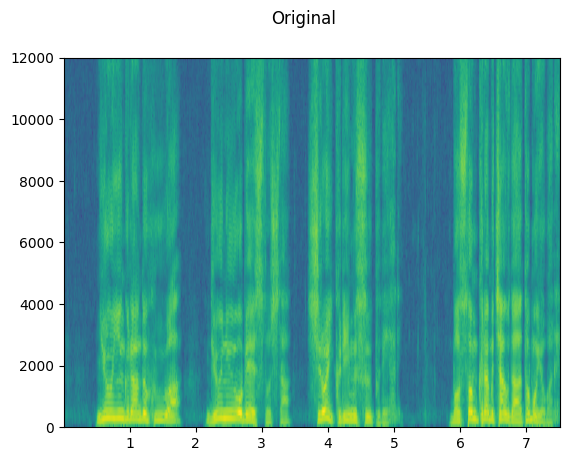

In [20]:
plot_specgram(torch.tensor([tmptmp]), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [21]:
y_mc = model(x_mc.unsqueeze(0).unsqueeze(0).to(torch.float), x_mc.unsqueeze(0).unsqueeze(0).to(torch.float)).squeeze(0).squeeze(0)
y_mc = y_mc.detach()

In [22]:
abs(x_mc).max()

tensor(10.2341, dtype=torch.float64)

In [23]:
abs(y_mc).max()

tensor(10.8971)

In [24]:
yy = synth(y_mc, x_f0, x_ap)

[[2.56761894e-07 2.66223509e-07 2.95658680e-07 ... 1.48145796e-06
  1.47946480e-06 1.47880053e-06]
 [2.04360106e-07 2.13081108e-07 2.40554215e-07 ... 9.13715894e-07
  9.12357166e-07 9.11904408e-07]
 [1.57338434e-07 1.63891613e-07 1.84507925e-07 ... 2.56299728e-07
  2.55874966e-07 2.55733426e-07]
 ...
 [8.74333928e-05 8.85851259e-05 9.20550447e-05 ... 4.51575261e-07
  4.51077767e-07 4.50911926e-07]
 [3.78852652e-04 3.83770879e-04 3.98556353e-04 ... 3.52308746e-07
  3.51895295e-07 3.51757478e-07]
 [2.32159020e-03 2.34852755e-03 2.42943945e-03 ... 3.81662375e-07
  3.81277999e-07 3.81149903e-07]]


In [25]:
import IPython.display
IPython.display.Audio(yy, rate=24000)

(1, 180240)


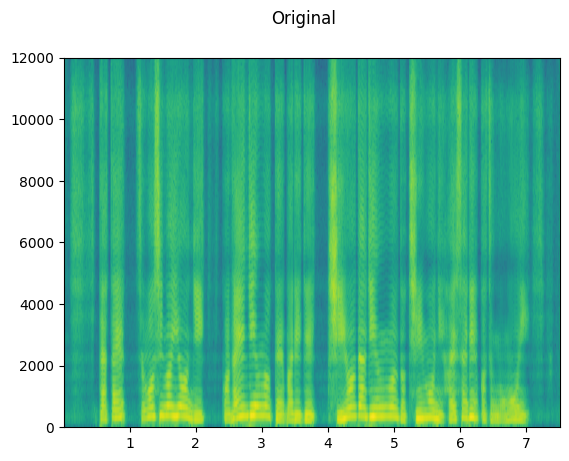

In [26]:
plot_specgram(torch.tensor([yy]), sample_rate=24000, title="Original")

In [27]:
import IPython.display
IPython.display.Audio("onsei/nanka.wav")